In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

import warnings

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

%matplotlib inline

%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True)
df = df[df.date > '2016-06'].reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2016-06-03,325.0,31.322,36.822,49.000,48.905,7.1945,7.216,1196.948,8.248,...,36.893488,32.772432,1.041334,60.121197,36.822,46.583235,36.822,49.971020,36.822,96.554255
1,2016-06-10,328.0,34.434,36.720,50.184,49.944,7.1560,7.133,1196.015,8.224,...,36.940973,32.761824,1.011001,60.325617,36.720,46.580276,36.720,49.813063,36.720,96.393339


In [4]:
# Remove wti_spot, brent_spot for redundant values with wti_spot_lag_14
#df = df.drop(['brent_spot'],axis=1)

# Noticed significant variation in early models that were not present in the majority of the data. 
# SelectKBest ended up adding much more significance to the world_cons data and caused modeling
# issues with MinMaxScaler... Same issues existed with StandardScaler

#df = df.drop(['world_cons','oecd_cons','non-oecd_cons','usa_net_import','usa_l48_prod'],axis=1)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,wti_spot_lag_9,wti_spot,brent_spot,usa_net_import_smooth,usa_net_import,usa_stocks_all,usa_l48_prod_smooth,...,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons
0,2016-06-03,325.0,31.322,36.822,49.000,48.905,7.1945,7.216,1196.948,8.248,...,36.893488,32.772432,1.041334,60.121197,36.822,46.583235,36.822,49.971020,36.822,96.554255
1,2016-06-10,328.0,34.434,36.720,50.184,49.944,7.1560,7.133,1196.015,8.224,...,36.940973,32.761824,1.011001,60.325617,36.720,46.580276,36.720,49.813063,36.720,96.393339


In [5]:
df.shape

(222, 21)

## Train Test Split
Define features X, and target variable y

In [6]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

date = df.date

model_score = pd.DataFrame(columns=['model','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

#scaler = MinMaxScaler()
#scaler.fit(df.iloc[:,1:])
#X = scaler.transform(df.iloc[:,1:])
#X = pd.DataFrame(X,columns=df.iloc[:,1:].columns)
#X[['Total US RigCount','wti_spot_lag_14']].plot(figsize=(12,10))

In [7]:
# Define functions
def plot_model(date,X,y,ts_cv,pipe,plot=True):

    mse_tt = []
    r2_tt = []
    mae_tt = []
    
    mse_tr = []
    r2_tr = []
    mae_tr = []
    
    if plot == True:
        fig, ax = plt.subplots(2, sharex=True, figsize=(18,10))
        ax[0].plot(date,y)
        ax[1].plot(date,y)
        ax[1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
        ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
        

        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            # Training data scores
            y_tr_pred = pipe.predict(X_tr)
            
            mse_tr.append(mean_squared_error(y_tr_pred,y_tr,squared=False))
            r2_tr.append(r2_score(y_tr_pred,y_tr))
            mae_tr.append(mean_absolute_error(y_tr_pred,y_tr))
            
            ax[0].plot(date[tr],y_tr_pred, label='train iter no'+str(ii+1))
            ax[0].legend()
            
            #Testing data scores
            y_tt_pred = pipe.predict(X_tt)
            
            mse_tt.append(mean_squared_error(y_tt_pred,y_tt,squared=False))
            r2_tt.append(r2_score(y_tt_pred,y_tt))
            mae_tt.append(mean_absolute_error(y_tt_pred,y_tt))
            
            ax[1].plot(date[tt],y_tt_pred, label='test iter no '+str(ii+1),)
            ax[1].legend()
            
        plt.xticks(rotation=75)
        plt.show()

    else:
        
        for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
            X_tr = X.iloc[tr,:]
            y_tr = y.iloc[tr]
            X_tt = X.iloc[tt,:]
            y_tt = y.iloc[tt]
            pipe.fit(X_tr,y_tr)

            # Training data scores
            y_tr_pred = pipe.predict(X_tr)
            
            mse_tr.append(mean_squared_error(y_tr_pred,y_tr,squared=False))
            r2_tr.append(r2_score(y_tr_pred,y_tr))
            mae_tr.append(mean_absolute_error(y_tr_pred,y_tr))
            
            #Testing data scores
            y_tt_pred = pipe.predict(X_tt)
            
            mse_tt.append(mean_squared_error(y_tt_pred,y_tt,squared=False))
            r2_tt.append(r2_score(y_tt_pred,y_tt))
            mae_tt.append(mean_absolute_error(y_tt_pred,y_tt))
            
    return np.mean(mse_tr), np.mean(r2_tr), np.mean(mae_tr), np.mean(mse_tt), np.mean(r2_tt), np.mean(mae_tt),

def add_model(model, errors):
    
    global model_score
    
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = errors
    
    row = {
        'model':model,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
    
    model_score = model_score.append(row,ignore_index=True)
    
    return errors

### Linear Regression 
Baseline model will be a linear regression with all features.

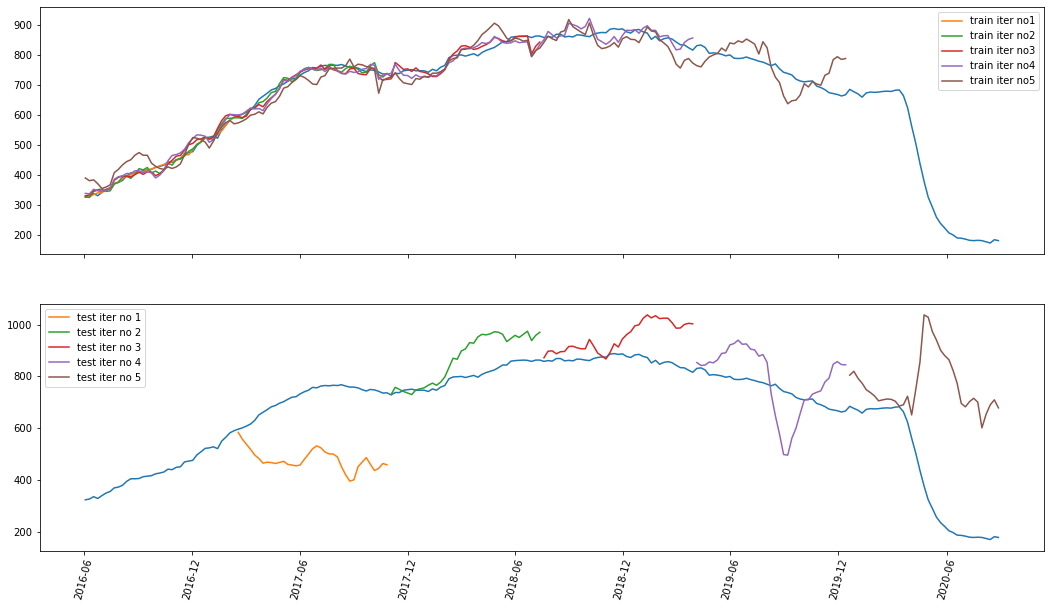

(19.107173561897508,
 0.9774293995665888,
 15.260886946386416,
 199.40862915532648,
 -11.844447059872735,
 168.84156005702386)

In [8]:
# Baseline linear regression with no additional features
n_splits = 5

model = LinearRegression()
cv = TimeSeriesSplit(n_splits=n_splits)
pipe = make_pipeline(model)

lin_base = plot_model(date,X,y,cv,pipe)
add_model('linear_base',lin_base)

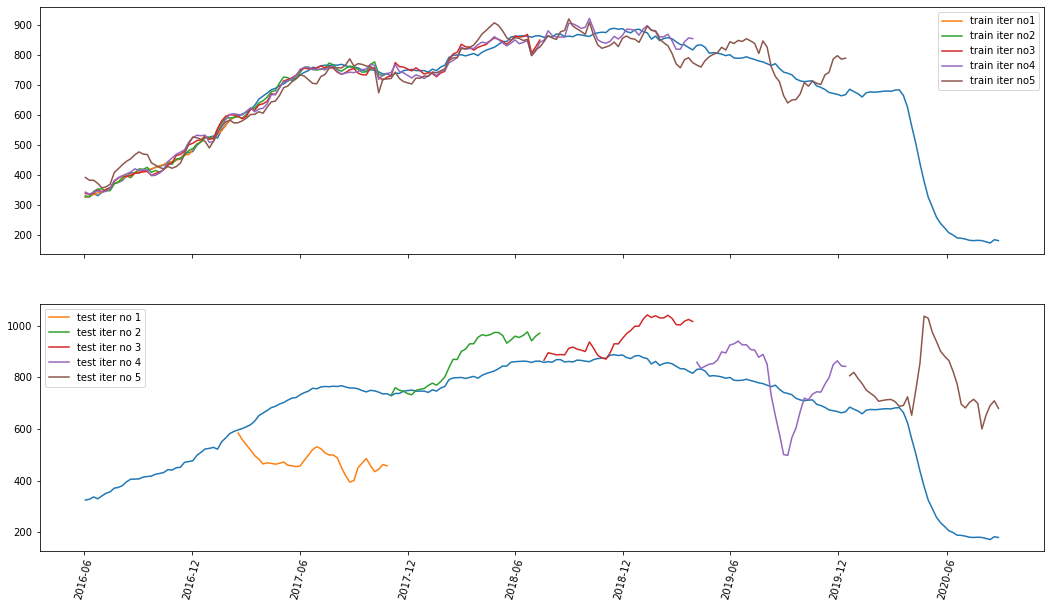

(18.89083320517061,
 0.9777078797475817,
 15.028793811352523,
 201.6101056537917,
 -11.728909028945084,
 170.612551997859)

In [9]:
# Add scaler to features
scaler = StandardScaler()
pipe = make_pipeline(scaler,model)

lin_scal = plot_model(date,X,y,cv,pipe)
add_model('linear_scaled',lin_scal)

In [ ]:
# Let's try with rolling window for the time series to account for the data being non-stationary

max_train_score = pd.DataFrame(columns=['n_splits','train_size','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')  

for n in np.arange(2,df.shape[0]):
    for i in np.arange(10,df.shape[0]):
        cv = TimeSeriesSplit(n_splits=n,max_train_size=i)

        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        row = {
            'n_splits':n,
            'train_size':i,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }

        max_train_score = max_train_score.append(row,ignore_index=True)
    
warnings.filterwarnings('default')  
    
max_train_score.sort_values(by='rmse_tt', inplace=True)
max_train_score.head()

In [ ]:
# Use 112 as the others are too small
max_train_best = int(max_train_score.train_size[max_train_score.index[0]])
n_splits_best = int(max_train_score.n_splits[max_train_score.index[0]])

cv = TimeSeriesSplit(n_splits=n_splits_best,max_train_size=max_train_best)

plot_model(date,X,y,cv,pipe)

In [ ]:
# Parameter tuning for SelectKBest - manual
k_score = pd.DataFrame(columns=['k','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')  

for i in np.arange(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    pipe = make_pipeline(scaler,feat_sel,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'k':i,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    k_score = k_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')  
    
k_score.sort_values(by='rmse_tr',inplace=True)
k_score.head()

In [ ]:
k_best = int(k_score.k[k_score.index[0]])

feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lin_kbest = plot_model(date,X,y,cv,pipe)
add_model('linear_kbest',lin_kbest)

In [ ]:
pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False)

In [ ]:
# Parameter tuning for linear regression - GridSearchCV
#feat_sel = SelectKBest(f_regression,k='all')
#pipe = make_pipeline(scaler,feat_sel,model)

#param_grid = {'selectkbest__k':np.arange(1,X.shape[1]+1)}

#gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=5,n_jobs=-1)

#plot_model(date,X,y,cv,gs_cv)

In [ ]:
#selected = gs_cv.best_estimator_.named_steps.selectkbest.get_support()
#coefs = gs_cv.best_estimator_.named_steps.linearregression.coef_
#features = pd.Series(coefs, index=X.columns[selected]).sort_values(ascending=False)

#print(gs_cv.best_params_)
#print(features)

### Ridge Regression 
Baseline model will be a ridge regression with default alpha.

In [ ]:
model = Ridge()
pipe = make_pipeline(scaler,model)

ridge_base = plot_model(date,X,y,cv,pipe)
add_model('ridge_base',ridge_base)

In [ ]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for j in np.arange(0.001,0.5,step=0.005):
    model = Ridge(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')  
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

In [ ]:
alpha_best = alpha_score.index[0]
model = Ridge(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

ridge_alpha = plot_model(date,X,y,cv,pipe)
add_model('ridge_alpha',ridge_alpha)

In [ ]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.1,0.5,step=0.001):
        model = Ridge(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)
        
warnings.filterwarnings('default')    

ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

In [ ]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Ridge(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

ridge_ak = plot_model(date,X,y,cv,pipe)
add_model('ridge_ak',ridge_ak)

In [ ]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

### Lasso Regression 
Baseline model will be a lasso regression with no alpha optimisation.

In [ ]:
model = Lasso()
pipe = make_pipeline(scaler,model)

lasso_base = plot_model(date,X,y,cv,model)
add_model('lasso_base',lasso_base)

In [ ]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

for j in np.arange(0.75,2,step=0.005):
    model = Lasso(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

In [ ]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = Lasso(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

lasso_alpha = plot_model(date,X,y,cv,pipe)
add_model('lasso_alpha',lasso_alpha)

In [ ]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.01,1,step=0.005):
        model = Lasso(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

In [ ]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = Lasso(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

lasso_ak = plot_model(date,X,y,cv,pipe)
add_model('lasso_ak',lasso_ak)

In [ ]:
print(pd.Series(model.coef_, index=X.columns[feat_sel.get_support()]).sort_values(ascending=False))

### ElasticNet Regression 
Baseline model will be a default ElasticNet regression

In [ ]:
model = ElasticNet()
pipe = make_pipeline(scaler,model)

elastic_base = plot_model(date,X,y,cv,model)
add_model('elastic_base',elastic_base)

In [ ]:
alpha_score = pd.DataFrame(columns=['alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for j in np.arange(0.001,0.1,step=0.0005):
    model = ElasticNet(alpha=j)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
    new_row = {
        'alpha':j,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }

    alpha_score = alpha_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')   
    
alpha_score.sort_values(by='rmse_tt',inplace=True)
alpha_score.head()

In [ ]:
alpha_best = alpha_score.alpha[alpha_score.index[0]]
model = ElasticNet(alpha=alpha_best)
pipe = make_pipeline(scaler,model)

elastic_alpha = plot_model(date,X,y,cv,pipe)
add_model('elastic_alpha',elastic_alpha)

In [ ]:
ak_score = pd.DataFrame(columns=['k','alpha','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(2,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for j in np.arange(0.001,0.2,step=0.001):
        model = ElasticNet(alpha=j)
        pipe = make_pipeline(scaler,feat_sel,model)
  
        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
        
        new_row = {
            'k':i,
            'alpha':j,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }
        
        ak_score = ak_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
ak_score.sort_values(by='rmse_tt',inplace=True)
ak_score.head()

In [ ]:
alpha_best = ak_score.alpha[ak_score.index[0]]
k_best = int(ak_score.k[ak_score.index[0]])

model = ElasticNet(alpha=alpha_best)
feat_sel = SelectKBest(f_regression,k=k_best)
pipe = make_pipeline(scaler,feat_sel,model)

elastic_ak = plot_model(date,X,y,cv,pipe)
add_model('elastic_ak',elastic_ak)

### Random Forest Regression 
Baseline model will be a default RF regression

In [ ]:
model = RandomForestRegressor(random_state=42)

pipe = make_pipeline(scaler,model)

rand_base = plot_model(date,X,y,cv,model)
add_model('rand_base',rand_base)

In [ ]:
est_score = pd.DataFrame(columns=['n_estimators','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

for n in np.arange(1,100,step=1):
    model = RandomForestRegressor(n_estimators = n)
    pipe = make_pipeline(scaler,model)
  
    rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)
    
    new_row = {
        'n_estimators':n,
        'rmse_tr':rmse_tr,
        'r2_tr':r2_tr,
        'mae_tr':mae_tr, 
        'rmse_tt':rmse_tt,
        'r2_tt':r2_tt,
        'mae_tt':mae_tt, 
    }
        
    est_score = est_score.append(new_row,ignore_index=True)
        
est_score.sort_values(by='rmse_tt',inplace=True)
est_score.head()

In [ ]:
est_best = int(est_score.n_estimators[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,model)

rand_est = plot_model(date,X,y,cv,pipe)
add_model('rand_est',rand_est)

In [ ]:
est_score = pd.DataFrame(columns=['k','n_estimate','rmse_tr','r2_tr','mae_tr','rmse_tt','r2_tt','mae_tt'])

warnings.filterwarnings('ignore')

for i in range(1,X.shape[1]+1):
    feat_sel = SelectKBest(f_regression,k=i)
    
    for n in np.arange(1,100,step=1):
        model = RandomForestRegressor(n_estimators = n)
        pipe = make_pipeline(scaler,feat_sel,model)

        rmse_tr, r2_tr, mae_tr, rmse_tt, r2_tt, mae_tt = plot_model(date,X,y,cv,pipe,plot=False)

        new_row = {
            'k':i,
            'n_estimate':n,
            'rmse_tr':rmse_tr,
            'r2_tr':r2_tr,
            'mae_tr':mae_tr, 
            'rmse_tt':rmse_tt,
            'r2_tt':r2_tt,
            'mae_tt':mae_tt, 
        }

        est_score = est_score.append(new_row,ignore_index=True)

warnings.filterwarnings('default')    
    
est_score.sort_values(by='rmse_tt',inplace=True)
est_score.head()

In [ ]:
est_best = int(est_score.n_estimate[est_score.index[0]])

model = RandomForestRegressor(n_estimators = est_best)
pipe = make_pipeline(scaler,feat_sel,model)

rand_nk = plot_model(date,X,y,cv,pipe)
add_model('rand_nk',rand_nk)

In [ ]:
model_score.sort_values(by='rmse_tt')

In [ ]:

lasso_ak